In [2]:
import pandas as pd
import kagglehub 
import torch 
from torch import nn
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from fast_ml.model_development import train_valid_test_split

In [3]:
path = kagglehub.dataset_download("mrmorj/hate-speech-and-offensive-language-dataset")

print("Path to dataset files:", path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Path to dataset files: /home/jupyter-st125490/.cache/kagglehub/datasets/mrmorj/hate-speech-and-offensive-language-dataset/versions/1


**The dataset is coming from kaggle hate speech and offensive language dataset from social media commentsa like tweets, containing 24783 samples**

In [4]:
x = pd.read_csv(path+'/labeled_data.csv')
x[['class', 'tweet']]

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,2,"you've gone and broke the wrong heart baby, an..."
24780,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,1,youu got wild bitches tellin you lies


**lets clean the data before training teacher student model**

In [5]:
train_data, test_data = train_test_split(x, test_size=0.2, random_state=42)

# Save as CSV for TabularDataset
# train_data.to_csv('train_data.csv', index=False)
# test_data.to_csv('test_data.csv', index=False)
# X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(x, target = 'class', 
#                                                                             train_size=0.6, valid_size=0.3, test_size=0.1)

# X_train['class'] = y_train
# X_valid['class'] = y_valid
# X_test['class'] = y_test


train_df, remaining_df = train_test_split(x, test_size=0.4, stratify=x['class'], random_state=42)

# Now split the remaining into validation and test sets
valid_df, test_df = train_test_split(remaining_df, test_size=0.5, stratify=remaining_df['class'], random_state=42)

In [6]:
# raw_data = MakeDataset(train_data, test_data)
# raw_data
import datasets
cols = ['tweet', 'class']
dd = datasets.DatasetDict({"train":Dataset.from_pandas(train_df[cols]),"valid":Dataset.from_pandas(valid_df[cols]),"test":Dataset.from_pandas(test_df[cols])})
dd

DatasetDict({
    train: Dataset({
        features: ['tweet', 'class', '__index_level_0__'],
        num_rows: 14869
    })
    valid: Dataset({
        features: ['tweet', 'class', '__index_level_0__'],
        num_rows: 4957
    })
    test: Dataset({
        features: ['tweet', 'class', '__index_level_0__'],
        num_rows: 4957
    })
})

In [7]:
import numpy as np 
num_labels = np.unique(dd['train']['class']).size
num_labels

3

In [8]:
label2id ={'hate_speech': 0, 'offensive_language': 1, 'neither': 2}
id2label = {0: 'hate_speech', 1: 'offensive_language', 2: 'neither'}

## Toeknization

In [9]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, 
     num_labels = num_labels,
    id2label = id2label,
    label2id = label2id)


teacher_model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

**Loaded BERT model of 12 layers**

In [11]:
def tokenize_function(examples):
    # Tokenize the 'tweet' column, ensuring truncation and padding
    result = tokenizer(examples['tweet'], max_length=128, truncation=True, padding='max_length')
    return result

In [12]:
tokenized_datasets = dd.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/14869 [00:00<?, ? examples/s]

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tweet', 'class', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 14869
    })
    valid: Dataset({
        features: ['tweet', 'class', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4957
    })
    test: Dataset({
        features: ['tweet', 'class', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4957
    })
})

In [13]:
print(tokenized_datasets['train']['input_ids'][0])  # Tokenized input IDs

[101, 19387, 1030, 4388, 24415, 4430, 4140, 14697, 1024, 2065, 2017, 2064, 2102, 3413, 1996, 2004, 3567, 2497, 2017, 2453, 2004, 2092, 2074, 2175, 2440, 2128, 7559, 2094, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [14]:
#remove column : 'premise', 'hypothesis', 'idx'
column_dataset = ['tweet']
tokenized_datasets = tokenized_datasets.remove_columns(column_dataset + ["__index_level_0__"])
#rename column : 'labels'
tokenized_datasets = tokenized_datasets.rename_column("class", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 14869
    })
    valid: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4957
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4957
    })
})

In [15]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

2025-03-23 06:08:23.352782: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742710103.371418  698691 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742710103.377403  698691 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-23 06:08:23.408628: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(12000))
small_test_dataset = tokenized_datasets["test"].shuffle(seed=1150).select(range(900))

In [17]:
# DataCollatorWithPadding ensures correct padding during batching
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create DataLoader for train and test datasets
# small_train_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(12000))
# small_test_dataset = tokenized_datasets["test"].shuffle(seed=1150).select(range(900))

train_dataloader = DataLoader(
    tokenized_datasets['train'], shuffle=False, batch_size=16, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_datasets['test'], batch_size=16, collate_fn=data_collator
)

valid_dataloader = DataLoader(
    tokenized_datasets['valid'], batch_size=16, collate_fn=data_collator
    
)

for batch in train_dataloader:
    break
    
batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


(torch.Size([16]), torch.Size([16, 128]), torch.Size([16, 128]))

## Modeling

**task 2.1 odd layers {1, 3, 5, 7, 9, 11}**

In [18]:
from transformers import BertModel, BertConfig
# Load the teacher model (12-layer model)
teacher_model = BertModel.from_pretrained(teacher_id)

# teacher_model = AutoModelForSequenceClassification.from_pretrained(
#     teacher_id, 
#      num_labels = num_labels,
#     id2label = id2label,
#     label2id = label2id,)
student_config = BertConfig.from_pretrained(teacher_id, num_hidden_layers=6, num_labels = num_labels)
student_model = BertModel(student_config)

In [17]:
# # Transfer weights for odd layers
# teacher_layers = teacher_model.encoder.layer  # List of layers in the teacher model
# student_layers = student_model.encoder.layer  # List of layers in the student model

# # Transfer weights from odd layers (0-indexed, so 1, 3, 5, 7, 9, 11 are indices 0, 2, 4, 6, 8, 10)
# for i, student_layer in enumerate(student_layers):
#     teacher_layer = teacher_layers[2*i]  # Select odd layers (i.e., layers 1, 3, 5, 7, 9, 11)
    
#     # Transfer weights for each component (e.g., attention, intermediate)
#     student_layer.attention.self.query.weight.data = teacher_layer.attention.self.query.weight.data.clone()
#     student_layer.attention.self.query.bias.data = teacher_layer.attention.self.query.bias.data.clone()
    
#     student_layer.attention.self.key.weight.data = teacher_layer.attention.self.key.weight.data.clone()
#     student_layer.attention.self.key.bias.data = teacher_layer.attention.self.key.bias.data.clone()
    
#     student_layer.attention.self.value.weight.data = teacher_layer.attention.self.value.weight.data.clone()
#     student_layer.attention.self.value.bias.data = teacher_layer.attention.self.value.bias.data.clone()
    
#     student_layer.attention.output.dense.weight.data = teacher_layer.attention.output.dense.weight.data.clone()
#     student_layer.attention.output.dense.bias.data = teacher_layer.attention.output.dense.bias.data.clone()
    
#     student_layer.intermediate.dense.weight.data = teacher_layer.intermediate.dense.weight.data.clone()
#     student_layer.intermediate.dense.bias.data = teacher_layer.intermediate.dense.bias.data.clone()
    
#     student_layer.output.dense.weight.data = teacher_layer.output.dense.weight.data.clone()
#     student_layer.output.dense.bias.data = teacher_layer.output.dense.bias.data.clone()


In [19]:
from transformers.models.bert.modeling_bert import BertModel, BertEncoder
from torch.nn import Module

def distill_bert_weights(teacher: Module, student: Module, odd_even: str) -> None:
    """
    Recursively copies the weights of the teacher model to the student model.
    This function copies one out of every two layers of the encoder.
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        # Iterate over children (BertModel contains encoder, pooler, and heads)
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights(teacher_part, student_part, odd_even)
    
    # Else if the part is an encoder, copy one out of every two layers (odd layers)
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = teacher.layer  # Access layers directly in teacher (BertEncoder)
        student_encoding_layers = student.layer  # Access layers directly in student (BertEncoder)

        print(f"Teacher encoding layers: {len(teacher_encoding_layers)}")
        print(f"Student encoding layers: {len(student_encoding_layers)}")

        # Ensure that the student model has fewer or equal layers compared to the teacher
        assert len(student_encoding_layers) * 2 <= len(teacher_encoding_layers), \
            "The student model should have fewer or equal layers compared to the teacher model."

        if odd_even == "odd":
            # Copy weights from odd layers (1, 3, 5, 7, 9, 11 -> 0, 2, 4, 6, 8, 10 in 0-indexing)
            for i in range(len(student_encoding_layers)):
                print(f"Copying from teacher layer {2 * i} to student layer {i}")
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[2 * i].state_dict())
        
        elif odd_even == "even":
            # Copy weights from even layers (2, 4, 6, 8, 10 -> 1, 3, 5, 7, 9 in 0-indexing)
            for i in range(len(student_encoding_layers)):
                if 2 * i + 1 < len(teacher_encoding_layers):  # Ensure you are not accessing out of bounds
                    print(f"Copying from teacher layer {2 * i + 1} to student layer {i}")
                    student_encoding_layers[i].load_state_dict(teacher_encoding_layers[2 * i + 1].state_dict())
                else:
                    # Handle the final layer if it doesn't exist in the even layers
                    print(f"Copying the final teacher layer {len(teacher_encoding_layers)-1} to student layer {i}")
                    student_encoding_layers[i].load_state_dict(teacher_encoding_layers[len(teacher_encoding_layers)-1].state_dict())
        
        else:
            raise ValueError("odd_even should be either 'odd' or 'even'")
    
    # Else the part is a head or something else, copy the state_dict directly
    else:
        # Directly copy the state_dict of this part (if it's not an encoder)
        student.load_state_dict(teacher.state_dict())

    return student


In [20]:
model = distill_bert_weights(teacher=teacher_model, student=student_model, odd_even="odd")

Teacher encoding layers: 12
Student encoding layers: 6
Copying from teacher layer 0 to student layer 0
Copying from teacher layer 2 to student layer 1
Copying from teacher layer 4 to student layer 2
Copying from teacher layer 6 to student layer 3
Copying from teacher layer 8 to student layer 4
Copying from teacher layer 10 to student layer 5


In [20]:
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# print('Teacher parameters :', count_parameters(teacher_model))
# print('Student parameters :', count_parameters(model))

In [21]:
# count_parameters(model)/count_parameters(teacher_model) * 100

In [21]:
import torch
import torch.nn.functional as F
from torch import nn

class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network.
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    Hyperparameters: temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities!
    """
    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Note: the output_student and output_teacher are logits
        '''
        T = temperature

        # Clip the logits to prevent extreme values (use a range to stabilize)
        output_student = torch.clamp(output_student, min=-10, max=10)
        output_teacher = torch.clamp(output_teacher, min=-10, max=10)

        # Apply temperature scaling
        scaled_student_logits = output_student / T
        scaled_teacher_logits = output_teacher / T

        # Compute KL Divergence loss
        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(scaled_student_logits, dim=-1),  # Log-softmax of student
            F.softmax(scaled_teacher_logits, dim=-1)       # Softmax of teacher
        ) * T * T  # Scaling by temperature squared

        return KD_loss


In [22]:
criterion_div = DistillKL()
criterion_cos = nn.CosineEmbeddingLoss()

In [23]:
from torch.optim import AdamW

# Define the optimizer for the student model
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)

# You can also define a learning rate scheduler (optional)
from transformers import get_linear_schedule_with_warmup
num_epochs = 5
# Define the number of training steps and warm-up steps for scheduler
num_training_steps = len(train_dataloader) * num_epochs
warmup_steps = int(0.1 * num_training_steps)  # 10% warm-up

# Create the scheduler for the learning rate decay
lr_scheduler = get_linear_schedule_with_warmup(optimizer,
                                               num_warmup_steps=warmup_steps,
                                               num_training_steps=num_training_steps)


In [24]:
num_epochs = 5
# Define the number of training steps and warm-up steps for scheduler
num_training_steps = len(train_dataloader) * num_epochs

In [25]:
model=model.to(device)
teacher_model = teacher_model.to(device)

**Training loop**

In [27]:
import torch
from torch.nn import CrossEntropyLoss
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0
# Lists to store losses for each epoch
train_losses_odd = []
train_losses_cls_odd = []
train_losses_div_odd = []
train_losses_cos_odd = []
eval_losses_odd = []
eval_accuracies_odd = []

for epoch in range(num_epochs):
    model.train()  # Ensure the student model is in training mode
    teacher_model.eval()  # Ensure the teacher model is in evaluation mode
    
    train_loss = 0
    train_loss_cls = 0
    train_loss_div = 0
    train_loss_cos = 0

    for batch in train_dataloader:
        # Move batch data to the appropriate device (GPU or CPU)
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Extract only the necessary inputs for the model
        input_batch = {k: v for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'token_type_ids']}
        
        # Ensure the input_batch is on the same device as the model
        input_batch = {k: v.to(device) for k, v in input_batch.items()}
        
        # Compute the student model output (using BertModel, without labels)
        outputs = model(**input_batch)
        # Compute the teacher model output (using BertModel, no gradients needed)
        with torch.no_grad():
            output_teacher = teacher_model(**input_batch)  # Get teacher logits
        
        # Get logits from the student and teacher (using [CLS] token representation)
        student_logits = outputs.last_hidden_state[:, 0, :].to(device)  # Ensure logits are on the correct device
        teacher_logits = output_teacher.last_hidden_state[:, 0, :].to(device)  # Ensure logits are on the correct device
        assert student_logits.size() == teacher_logits.size()

        
        # Initialize loss components
        loss_cls = None
        total_loss = None
        
        # Compute loss only if labels are provided
        if 'labels' in batch:
            labels = batch['labels'].to(device)  # Get labels and move to device
            criterion_cls = CrossEntropyLoss()
            loss_cls = criterion_cls(student_logits, labels)  # Cross-entropy loss for classification
            train_loss_cls += loss_cls.item()

            # Combine the losses (distillation and classification)
            loss_div = criterion_div(student_logits, teacher_logits)  # Distillation loss (e.g., KL divergence)
            train_loss_div += loss_div.item()
            
            loss_cos = criterion_cos(teacher_logits, student_logits, torch.ones(student_logits.size(0)).to(device))  # Cosine loss
            train_loss_cos += loss_cos.item()
            # print(loss_cls)
            # print(loss_div)
            # print(loss_cos)
            # # Total loss (classification loss + distillation loss + cosine loss)
            total_loss = (loss_cls + loss_div + loss_cos) / 3
        else:
            # If there are no labels, just use distillation loss and cosine loss
            loss_div = criterion_div(student_logits, teacher_logits)
            loss_cos = criterion_cos(teacher_logits, student_logits, torch.ones(student_logits.size(0)).to(device))
            total_loss = (loss_div + loss_cos) / 2

        if torch.isnan(student_logits).any() or torch.isinf(student_logits).any():
            print("NaN or Inf detected in student logits")

        if torch.isnan(teacher_logits).any() or torch.isinf(teacher_logits).any():
            print("NaN or Inf detected in teacher logits")

        # Backpropagation
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        lr_scheduler.step()

        # Update progress bar
        progress_bar.update(1)

        # Accumulate the training loss
        train_loss += total_loss.item()

    # Average loss for the epoch
    train_losses_odd.append(train_loss / len(train_dataloader))
    train_losses_cls_odd.append(train_loss_cls / len(train_dataloader))
    train_losses_div_odd.append(train_loss_div / len(train_dataloader))
    train_losses_cos_odd.append(train_loss_cos / len(train_dataloader))

    print(f'Epoch {epoch + 1}: Train Loss {train_loss / len(train_dataloader):.4f}')
    print(f'  - Loss_cls: {train_loss_cls / len(train_dataloader):.4f}')
    print(f'  - Loss_div: {train_loss_div / len(train_dataloader):.4f}')
    print(f'  - Loss_cos: {train_loss_cos / len(train_dataloader):.4f}')

     # Now evaluate on the test set
    student_model.eval()  # Switch model to evaluation mode

    eval_loss = 0
    correct_predictions = 0
    total_predictions = 0

    # Loop over test data
    with torch.no_grad():
        for batch in valid_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            
            input_batch = {k: v for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'token_type_ids']}
            labels = batch['labels'].to(device)  # Get labels

            # Forward pass for the student model
            outputs = model(**input_batch)
            logits = outputs.last_hidden_state[:, 0, :].to(device)

            # Compute the classification loss
            criterion_cls = nn.CrossEntropyLoss()
            loss_cls = criterion_cls(logits, labels)
            eval_loss += loss_cls.item()

            # Get predictions
            predictions = logits.argmax(dim=-1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

    eval_accuracy = correct_predictions / total_predictions
    eval_losses_odd.append(eval_loss / len(test_dataloader))
    eval_accuracies_odd.append(eval_accuracy)
    
    print(f"Epoch {epoch + 1}: Eval Loss: {eval_loss / len(test_dataloader):.4f}, Eval Accuracy: {eval_accuracy:.4f}")


  0%|          | 0/4650 [00:00<?, ?it/s]

Epoch 1: Train Loss 0.9493
  - Loss_cls: 1.8127
  - Loss_div: 0.6656
  - Loss_cos: 0.3696
Epoch 1: Eval Loss: 0.9422, Eval Accuracy: 0.8921
Epoch 2: Train Loss 0.6560
  - Loss_cls: 1.0501
  - Loss_div: 0.7094
  - Loss_cos: 0.2087
Epoch 2: Eval Loss: 0.9113, Eval Accuracy: 0.9068
Epoch 3: Train Loss 0.6291
  - Loss_cls: 0.9951
  - Loss_div: 0.7016
  - Loss_cos: 0.1905
Epoch 3: Eval Loss: 0.9650, Eval Accuracy: 0.9046
Epoch 4: Train Loss 0.6145
  - Loss_cls: 0.9622
  - Loss_div: 0.6996
  - Loss_cos: 0.1817
Epoch 4: Eval Loss: 0.8885, Eval Accuracy: 0.9145
Epoch 5: Train Loss 0.6068
  - Loss_cls: 0.9442
  - Loss_div: 0.6984
  - Loss_cos: 0.1779
Epoch 5: Eval Loss: 0.8910, Eval Accuracy: 0.9151


In [26]:
model_odd = model
# torch.save(model_odd, "odd_model")

**task 2.2 even {2, 4, 6, 8, 10, 12}**

In [27]:
student_config = BertConfig.from_pretrained(teacher_id, num_hidden_layers=6, num_labels = num_labels)
student_model = BertModel(student_config)
model = distill_bert_weights(teacher=teacher_model, student=student_model, odd_even="even")
model=model.to(device)

Teacher encoding layers: 12
Student encoding layers: 6
Copying from teacher layer 1 to student layer 0
Copying from teacher layer 3 to student layer 1
Copying from teacher layer 5 to student layer 2
Copying from teacher layer 7 to student layer 3
Copying from teacher layer 9 to student layer 4
Copying from teacher layer 11 to student layer 5


In [33]:
#train model with the similar settings
from tqdm.auto import tqdm
from torch.nn import CrossEntropyLoss
progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0
# Lists to store losses for each epoch
train_losses = []
train_losses_cls = []
train_losses_div = []
train_losses_cos = []
eval_losses = []
eval_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Ensure the student model is in training mode
    teacher_model.eval()  # Ensure the teacher model is in evaluation mode
    
    train_loss = 0
    train_loss_cls = 0
    train_loss_div = 0
    train_loss_cos = 0

    for batch in train_dataloader:
        # Move batch data to the appropriate device (GPU or CPU)
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Extract only the necessary inputs for the model
        input_batch = {k: v for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'token_type_ids']}
        
        # Ensure the input_batch is on the same device as the model
        input_batch = {k: v.to(device) for k, v in input_batch.items()}
        
        # Compute the student model output (using BertModel, without labels)
        outputs = model(**input_batch)
        # Compute the teacher model output (using BertModel, no gradients needed)
        with torch.no_grad():
            output_teacher = teacher_model(**input_batch)  # Get teacher logits
        
        # Get logits from the student and teacher (using [CLS] token representation)
        student_logits = outputs.last_hidden_state[:, 0, :].to(device)  # Ensure logits are on the correct device
        teacher_logits = output_teacher.last_hidden_state[:, 0, :].to(device)  # Ensure logits are on the correct device
        assert student_logits.size() == teacher_logits.size()

        
        # Initialize loss components
        loss_cls = None
        total_loss = None
        
        # Compute loss only if labels are provided
        if 'labels' in batch:
            labels = batch['labels'].to(device)  # Get labels and move to device
            criterion_cls = CrossEntropyLoss()
            loss_cls = criterion_cls(student_logits, labels)  # Cross-entropy loss for classification
            train_loss_cls += loss_cls.item()

            # Combine the losses (distillation and classification)
            loss_div = criterion_div(student_logits, teacher_logits)  # Distillation loss (e.g., KL divergence)
            train_loss_div += loss_div.item()
            
            loss_cos = criterion_cos(teacher_logits, student_logits, torch.ones(student_logits.size(0)).to(device))  # Cosine loss
            train_loss_cos += loss_cos.item()
            # print(loss_cls)
            # print(loss_div)
            # print(loss_cos)
            # # Total loss (classification loss + distillation loss + cosine loss)
            total_loss = (loss_cls + loss_div + loss_cos) / 3
        else:
            # If there are no labels, just use distillation loss and cosine loss
            loss_div = criterion_div(student_logits, teacher_logits)
            loss_cos = criterion_cos(teacher_logits, student_logits, torch.ones(student_logits.size(0)).to(device))
            total_loss = (loss_div + loss_cos) / 2

        if torch.isnan(student_logits).any() or torch.isinf(student_logits).any():
            print("NaN or Inf detected in student logits")

        if torch.isnan(teacher_logits).any() or torch.isinf(teacher_logits).any():
            print("NaN or Inf detected in teacher logits")

        # Backpropagation
        total_loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        # Update progress bar
        progress_bar.update(1)

        # Accumulate the training loss
        train_loss += total_loss.item()

    # Average loss for the epoch
    train_losses.append(train_loss / len(train_dataloader))
    train_losses_cls.append(train_loss_cls / len(train_dataloader))
    train_losses_div.append(train_loss_div / len(train_dataloader))
    train_losses_cos.append(train_loss_cos / len(train_dataloader))

    print(f'Epoch {epoch + 1}: Train Loss {train_loss / len(train_dataloader):.4f}')
    print(f'  - Loss_cls: {train_loss_cls / len(train_dataloader):.4f}')
    print(f'  - Loss_div: {train_loss_div / len(train_dataloader):.4f}')
    print(f'  - Loss_cos: {train_loss_cos / len(train_dataloader):.4f}')

     # Now evaluate on the test set
    student_model.eval()  # Switch model to evaluation mode

    eval_loss = 0
    correct_predictions = 0
    total_predictions = 0

    # Loop over test data
    with torch.no_grad():
        for batch in valid_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            
            input_batch = {k: v for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'token_type_ids']}
            labels = batch['labels'].to(device)  # Get labels

            # Forward pass for the student model
            outputs = model(**input_batch)
            logits = outputs.last_hidden_state[:, 0, :].to(device)

            # Compute the classification loss
            criterion_cls = nn.CrossEntropyLoss()
            loss_cls = criterion_cls(logits, labels)
            eval_loss += loss_cls.item()

            # Get predictions
            predictions = logits.argmax(dim=-1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

    eval_accuracy = correct_predictions / total_predictions
    eval_losses.append(eval_loss / len(test_dataloader))
    eval_accuracies.append(eval_accuracy)
    
    print(f"Epoch {epoch + 1}: Eval Loss: {eval_loss / len(test_dataloader):.4f}, Eval Accuracy: {eval_accuracy:.4f}")


  0%|          | 0/4650 [00:00<?, ?it/s]

Epoch 1: Train Loss 0.9637
  - Loss_cls: 2.0150
  - Loss_div: 0.5734
  - Loss_cos: 0.3027
Epoch 1: Eval Loss: 0.9699, Eval Accuracy: 0.8941
Epoch 2: Train Loss 0.6684
  - Loss_cls: 1.0732
  - Loss_div: 0.6763
  - Loss_cos: 0.2556
Epoch 2: Eval Loss: 0.9639, Eval Accuracy: 0.8973
Epoch 3: Train Loss 0.6424
  - Loss_cls: 1.0132
  - Loss_div: 0.6761
  - Loss_cos: 0.2378
Epoch 3: Eval Loss: 0.9675, Eval Accuracy: 0.9020
Epoch 4: Train Loss 0.6284
  - Loss_cls: 0.9789
  - Loss_div: 0.6778
  - Loss_cos: 0.2285
Epoch 4: Eval Loss: 0.9572, Eval Accuracy: 0.9124
Epoch 5: Train Loss 0.6212
  - Loss_cls: 0.9607
  - Loss_div: 0.6781
  - Loss_cos: 0.2248
Epoch 5: Eval Loss: 0.9250, Eval Accuracy: 0.9137


In [28]:
model_even = model
# torch.save(model_even, "even_model")

**Analysis**

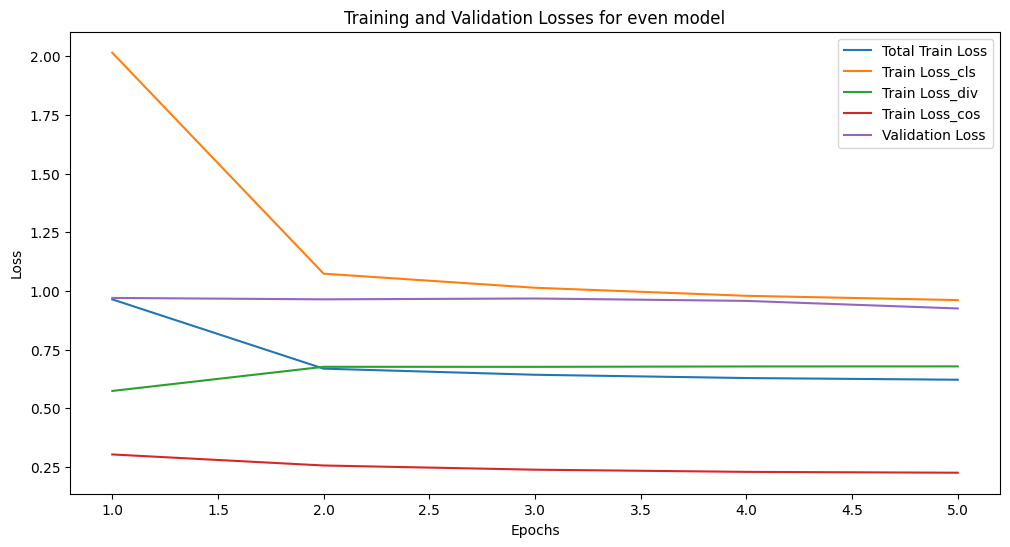

In [36]:
import matplotlib.pyplot as plt
# Plotting
epochs_list = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_losses, label='Total Train Loss')
plt.plot(epochs_list, train_losses_cls, label='Train Loss_cls')
plt.plot(epochs_list, train_losses_div, label='Train Loss_div')
plt.plot(epochs_list, train_losses_cos, label='Train Loss_cos')
plt.plot(epochs_list, eval_losses, label='Validation Loss')

plt.title('Training and Validation Losses for even model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

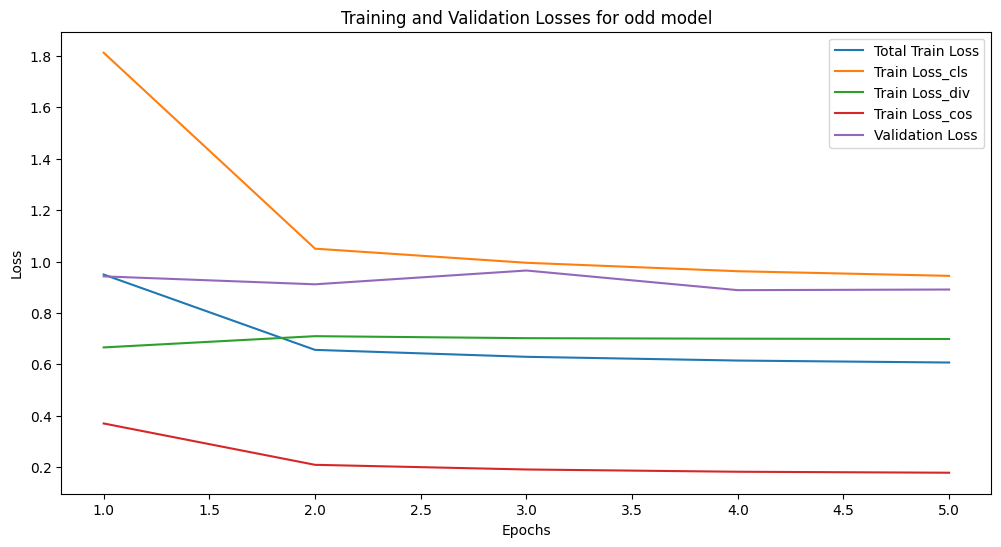

In [37]:
import matplotlib.pyplot as plt
# Plotting
epochs_list = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_losses_odd, label='Total Train Loss')
plt.plot(epochs_list, train_losses_cls_odd, label='Train Loss_cls')
plt.plot(epochs_list, train_losses_div_odd, label='Train Loss_div')
plt.plot(epochs_list, train_losses_cos_odd, label='Train Loss_cos')
plt.plot(epochs_list, eval_losses_odd, label='Validation Loss')

plt.title('Training and Validation Losses for odd model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Excluding the data being imbalanced in the validation set the even and odd layers follow the same pattren**

## Task3 LoRA implementation

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# LoRA class definition
class LoRA(nn.Module):
    def __init__(self, layer, r=4):
        """
        Apply LoRA to a given layer.
        `r` is the rank of the low-rank update (this can be adjusted)
        """
        super(LoRA, self).__init__()
        self.layer = layer
        self.r = r
        
        # Create low-rank matrices (for LoRA)
        self.A = nn.Parameter(torch.randn(self.layer.weight.size(0), self.r))
        self.B = nn.Parameter(torch.randn(self.r, self.layer.weight.size(1)))
        
        # Freeze original weights during training
        self.layer.weight.requires_grad = False
        
    def forward(self, x):
        # Perform the LoRA low-rank update
        return F.linear(x, self.layer.weight + torch.matmul(self.A, self.B))

# Function to apply LoRA to layers (odd/even) of the model
def apply_lora_to_layers(student_model, odd_even="odd"):
    """
    Apply LoRA to odd/even layers of the student model
    `odd_even` should be "odd" or "even"
    """
    layers_to_update = []
    layer_count = 0  # To track the layer order (odd/even)
    
    # Iterate over the modules to collect layers to apply LoRA to
    for name, module in student_model.named_modules():
        if isinstance(module, nn.Linear):
            # Increment the layer count for each Linear layer
            layer_count += 1
            
            # Apply LoRA to odd or even layers based on layer_count
            if odd_even == "odd" and layer_count % 2 == 1:
                layers_to_update.append((name, module))
            elif odd_even == "even" and layer_count % 2 == 0:
                layers_to_update.append((name, module))
    
    # Now, replace the layers
    for name, module in layers_to_update:
        student_model._modules[name] = LoRA(module)
    
    return student_model

# Example usage in training loop:
# Assuming `teacher_model` is a pre-trained model and `student_model` is initialized

model_even.load_state_dict(torch.load("even_model_weights.pth"), strict=False)
model_odd.load_state_dict(torch.load("odd_model_weights.pth"), strict=False)
student_model_lora_odd = apply_lora_to_layers(model_odd, odd_even="odd")  # Apply LoRA to odd layers
student_model_lora_even = apply_lora_to_layers(model_even, odd_even="even")  # Apply LoRA to even layers

# Proceed with training the model as usual
student_model_lora_odd=student_model_lora_odd.to(device)
student_model_lora_even = student_model_lora_even.to(device)

In [49]:
# torch.save(model_even.state_dict(), "even_model_weights.pth")
# torch.save(model_odd.state_dict(), "odd_model_weights.pth")

In [30]:
student_model_lora_odd

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-5): 6 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
    

In [51]:
for param in student_model_lora_odd.parameters():
    param.requires_grad = False

# Enable LoRA parameters to be updated
for name, module in student_model_lora_odd.named_modules():
    if isinstance(module, LoRA):
        for param in module.parameters():
            param.requires_grad = True

In [37]:
from torch.optim import AdamW
import torch.nn as nn
import torch

# Initialize optimizer with a small learning rate
criterion_cls = nn.CrossEntropyLoss()
num_epochs = 3
# Training loop
def train(student_model_lora, train_dataloader, valid_dataloader, num_epochs, device):
    optimizer = AdamW(student_model_lora.parameters(), lr=5e-5, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)  # Learning rate scheduler
    
    for epoch in range(num_epochs):
        student_model_lora.train()
        
        total_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            
            input_batch = {k: v for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'token_type_ids']}
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = student_model_lora(**input_batch)
            logits = outputs.last_hidden_state[:, 0, :]  # BERT-based: use first token as representation
            
            # Compute loss
            loss_cls = criterion_cls(logits, labels)
            
            # Backpropagation
            optimizer.zero_grad()
            loss_cls.backward()
            
            # Gradient clipping to prevent explosion
            torch.nn.utils.clip_grad_norm_(student_model_lora.parameters(), max_norm=1.0)
            
            # Optimizer step
            optimizer.step()
    
            total_loss += loss_cls.item()
            predictions = logits.argmax(dim=-1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
        
        # Calculate average training loss and accuracy
        train_loss = total_loss / len(train_dataloader)
        train_accuracy = correct_predictions / total_predictions
        
        print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    
        # Evaluation phase
        student_model_lora.eval()
        eval_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        with torch.no_grad():
            for batch in valid_dataloader:
                batch = {k: v.to(device) for k, v in batch.items()}
                input_batch = {k: v for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'token_type_ids']}
                labels = batch['labels'].to(device)
    
                outputs = student_model_lora(**input_batch)
                logits = outputs.last_hidden_state[:, 0, :]
                
                # Compute loss
                loss_cls = criterion_cls(logits, labels)
                eval_loss += loss_cls.item()
    
                predictions = logits.argmax(dim=-1)
                correct_predictions += (predictions == labels).sum().item()
                total_predictions += labels.size(0)
        
        eval_accuracy = correct_predictions / total_predictions
        eval_loss /= total_predictions  # Normalize by the number of examples
        
        print(f"Epoch {epoch + 1}: Eval Loss: {eval_loss:.4f}, Eval Accuracy: {eval_accuracy:.4f}")
        
        # Step the scheduler based on eval loss
        scheduler.step(eval_loss)

# Example usage
train(student_model_lora_odd, train_dataloader, valid_dataloader, num_epochs=3, device=device)


Epoch 1: Train Loss: 0.2851, Train Accuracy: 0.9164
Epoch 1: Eval Loss: 0.0231, Eval Accuracy: 0.8963
Epoch 2: Train Loss: 0.2101, Train Accuracy: 0.9379
Epoch 2: Eval Loss: 0.0252, Eval Accuracy: 0.9064
Epoch 3: Train Loss: 0.1496, Train Accuracy: 0.9592
Epoch 3: Eval Loss: 0.0316, Eval Accuracy: 0.9046


**The evaluation loss is increasing because our model above is overfitting in order to balanace the score**

In [39]:
train(student_model_lora_even, train_dataloader, valid_dataloader, num_epochs=3, device=device)

Epoch 1: Train Loss: 0.2847, Train Accuracy: 0.9172
Epoch 1: Eval Loss: 0.0242, Eval Accuracy: 0.8897
Epoch 2: Train Loss: 0.1971, Train Accuracy: 0.9412
Epoch 2: Eval Loss: 0.0278, Eval Accuracy: 0.8876
Epoch 3: Train Loss: 0.1357, Train Accuracy: 0.9654
Epoch 3: Eval Loss: 0.0344, Eval Accuracy: 0.8983


**Similar pattren but close the evaluation loss is fluctuating**

**Analysis of Lora with initiallized even and odd distilled model on test data**

Eval Loss: 0.0346
Eval Loss: 0.0324


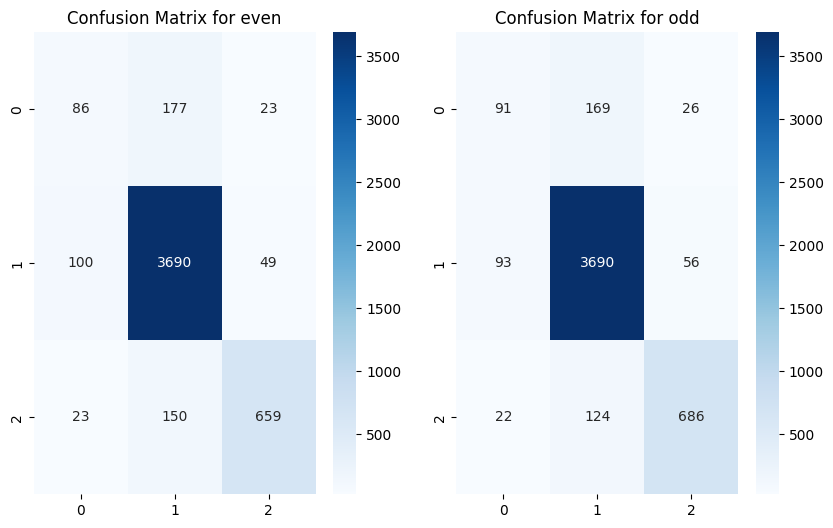

In [56]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate predictions
def confusion_matrix_(model):
    eval_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for batch in test_dataloader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs)
            logits = outputs.last_hidden_state[:, 0, :]
            predictions = logits.argmax(dim=-1)
            loss_cls = criterion_cls(logits, labels)
            eval_loss += loss_cls.item()
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
            
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        eval_accuracy = correct_predictions / total_predictions
        eval_loss /= total_predictions  # Normalize by the number of examples
        print(f"Eval Loss: {eval_loss:.4f}")
    return all_labels, all_preds

# Confusion matrix and classification report
all_labels_even, all_preds_even=confusion_matrix_(student_model_lora_even)
all_labels_odd, all_preds_odd=confusion_matrix_(student_model_lora_odd)

cm_even = confusion_matrix(all_labels_even, all_preds_even)
cm_odd = confusion_matrix(all_labels_odd, all_preds_odd)
fig, ax =plt.subplots(1,2, figsize=(10, 6))
sns.heatmap(cm_even, annot=True, fmt='d', cmap='Blues', ax=ax[0])
sns.heatmap(cm_odd, annot=True, fmt = 'd', cmap='Blues', ax = ax[1])

ax[0].set_title('Confusion Matrix for even')
ax[1].set_title("Confusion Matrix for odd")
plt.show()

In [59]:
from IPython.display import display, HTML
import pandas as pd
v=pd.DataFrame(columns =['Model Type', 'Traning Loss', 'Test Set Performance'])
v['Model Type'] = ['even_distilled', 'odd_distilled', 'even_lora_init', 'odd_lora_init']
v['Traning Loss'] = ['0.6212', '0.6068', ' 0.1357', '0.1496']
v['Test Set Performance'] = ['0.9250', '0.8910', '0.0346', '0.0324']
display(v)

,Model Type,Traning Loss,Test Set Performance
0,even_distilled,0.6212,0.9250
1,odd_distilled,0.6068,0.8910
2,even_lora_init,0.1357,0.0346
3,odd_lora_init,0.1496,0.0324


In [60]:
#save the models

torch.save(student_model_lora_even, "student_model_lora_even")
torch.save(student_model_lora_odd, "student_model_lora_odd")

torch.save(student_model_lora_even.state_dict(), "lora_even_weight.pth")
torch.save(student_model_lora_odd.state_dict(), "lora_odd_weights.pth")

In [87]:
def load_lora_model(model_path, i,weights_path, odd_even="odd", r=4, device='cuda'):
    """
    Load a pre-trained model and apply LoRA to its layers.
    `odd_even` should be "odd" or "even".
    """
    # Load the pre-trained model (assuming it's a BERT model or similar)
    model_weights = torch.load(i)
    model = torch.load(model_path, weights_only=False)
    model.load_state_dict(model_weights, strict=False)

    # Apply LoRA to either odd or even layers
    model_lora = apply_lora_to_layers(model, odd_even=odd_even)
    
    # Load the weights (LoRA weights and original model weights)
    model_lora.load_state_dict(torch.load(weights_path), strict=False)
    
    # Move the model to the desired device (GPU or CPU)
    model_lora = model_lora.to(device)
    
    return model_lora

model=load_lora_model("odd_model", i = "odd_model_weights.pth", weights_path="lora_odd_weights.pth")
model = model.to("cpu")

In [88]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-5): 6 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
    

In [85]:
import torch
from transformers import AutoTokenizer

# Tokenizer and model setup
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Tokenize function to handle userinput
def tokenize_function(example):
    # Tokenize the input, ensuring truncation and padding
    result = tokenizer(example, max_length=128, truncation=True, padding='max_length', return_tensors='pt')
    return result

tokenized_input = tokenize_function("this is nice")

with torch.no_grad():
    outputs = model(**tokenized_input)
    logits = outputs.last_hidden_state[:, 0, :]
    probabilities = torch.softmax(logits, dim=-1)
    predicted_label = logits.argmax(dim=-1).item()
    print(predicted_label)
    

    


2


In [66]:
model_even=torch.load("student_model_lora_odd", weights_only=False)
model_even.load_state_dict(torch.load("lora_odd_weights.pth"), strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['encoder.layer.0.attention.self.query.A', 'encoder.layer.0.attention.self.query.B', 'encoder.layer.0.attention.self.query.layer.weight', 'encoder.layer.0.attention.self.query.layer.bias', 'encoder.layer.0.attention.self.value.A', 'encoder.layer.0.attention.self.value.B', 'encoder.layer.0.attention.self.value.layer.weight', 'encoder.layer.0.attention.self.value.layer.bias', 'encoder.layer.0.intermediate.dense.A', 'encoder.layer.0.intermediate.dense.B', 'encoder.layer.0.intermediate.dense.layer.weight', 'encoder.layer.0.intermediate.dense.layer.bias', 'encoder.layer.1.attention.self.query.A', 'encoder.layer.1.attention.self.query.B', 'encoder.layer.1.attention.self.query.layer.weight', 'encoder.layer.1.attention.self.query.layer.bias', 'encoder.layer.1.attention.self.value.A', 'encoder.layer.1.attention.self.value.B', 'encoder.layer.1.attention.self.value.layer.weight', 'encoder.layer.1.attention.self.value.layer.bias', 'encoder.layer.1

## challanges and insights

* The primary challange is to stop BERT to not overfit, the model tend to overfit, even though we tried various way after removing the lr_scheduler the performance was worst the learning become so slow, this was true for both even and model
* with distiled training we tried to as decay the able to control the overfit
* with the Lora model the performance start imporving but was strange at first because we obeserve exploding gradients, and we did some research regarding this the finding was that the smaller model tend to have exploding gradings and overfit quickers we use gradient clipping to mitigite.
* The performance of lora looks like stabelizing the performance since the models are overfitting the evaluation loss is fluctuating but the accuracy still reduced there could two resons since lora is low rank decompotion it tend to learn the petterens of imbalance size classes and the model tend to have better accuracy

---